In [131]:
import torch
%matplotlib nbagg
import torch.nn as nn
import torch.optim as optim
import json
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
import numpy as np
import mplhep as hep

hep.style.use("CMS")


df = pd.read_parquet(r'C:\Users\drpla\Desktop\ICL-PHYSICS-YEAR-4\Masters Project\Data\New folder\merged_nominal.parquet')

with open(r'C:\Users\drpla\Desktop\ICL-PHYSICS-YEAR-4\Masters Project\Data\New folder\summary.json', "r") as f:
  proc_dict = json.load(f)["sample_id_map"]
  
signalname="GluGluToRadionToHHTo2G2Tau_M-260"
sig = df[df.process_id == proc_dict[f"{signalname}"]] # just one signal process, mass of X is 1000 GeV
sig['Classification']=np.ones(sig['Diphoton_mass'].size)
#bkg = df[df.process_id == proc_dict["DiPhoton"]] # just one of the background processes

C:\Users\drpla\AppData\Local\Temp\ipykernel_4136\2813884105.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sig['Classification']=np.ones(sig['Diphoton_mass'].size)


In [132]:
"""Concatenating the background data"""
background_list=['Data','DiPhoton', 'TTGG', 'TTGamma',#list of each bkgs for concatenation
 'TTJets',
 'VBFH_M125',
 'VH_M125',
 'WGamma',
 'ZGamma',
 'ggH_M125', 
 'ttH_M125',
 'GJets']

listforconc=[]
for i in background_list:                               #creating a concatenated list of bkg
    bkgg = df[df.process_id == proc_dict[i]]
    listforconc.append(bkgg)
    
background = pd.concat(listforconc)
background['Classification']=np.zeros(background['Diphoton_mass'].size)

In [133]:
MinusNineBinning=['ditau_met_dPhi',
                  'ditau_deta',
                  'ditau_dR',
                  'ditau_dphi',
                  'ditau_pt',
                  'Diphoton_ditau_dphi',
                  'dilep_leadpho_mass',
                  'reco_MX_mgg',
                  'Diphoton_ditau_deta',
                  'Diphoton_sublead_lepton_deta',
                  'Diphoton_sublead_lepton_dR',
                  'LeadPhoton_ditau_dR',
                  'ditau_mass']


In [4]:

# "rescale all of signal up to the number of background weighting"

# """DONT RUN THIS
# By the end of preprocessing data the weights are not even
# this should occur after the data is split
# """


# #print(background['weight_central'].sum(),sig['weight_central'].sum())

# scale=background['weight_central'].sum()/sig['weight_central'].sum()

# sig['weight_central'] = sig['weight_central']*scale

# #print(sig['weight_central'].sum())

In [134]:
"""Concatenating Signal and Background"""
"""Choosing Best Features given the M=1000 AUC scores"""
FullSignalBackground=pd.concat([sig,background])

df_TopFeatures=pd.DataFrame()

TopFeatures=['reco_MX_mgg','Diphoton_pt_mgg','LeadPhoton_pt_mgg','ditau_pt','Diphoton_dPhi','dilep_leadpho_mass','lead_lepton_pt','MET_pt','ditau_dR','SubleadPhoton_pt_mgg','Diphoton_lead_lepton_deta','ditau_met_dPhi','ditau_deta','Diphoton_sublead_lepton_deta','Diphoton_ditau_deta','ditau_mass','weight_central','Classification']
#TopFeatures=['reco_MX_mgg','Diphoton_pt_mgg','LeadPhoton_pt_mgg','ditau_pt','Diphoton_dPhi','dilep_leadpho_mass','lead_lepton_pt','MET_pt','ditau_dR','SubleadPhoton_pt_mgg','weight_central','Classification']


for feature in TopFeatures:
    df_TopFeatures[feature]=FullSignalBackground[feature]
    
#for columns in MinusNineBinning:
 #   if columns in df_TopFeatures.columns:
  #      df_TopFeatures[columns] = df_TopFeatures[columns].mask(df_TopFeatures[columns] < -8, 0)
   
for columns in df_TopFeatures.columns:
    if columns in MinusNineBinning:
    #    print(columns)
        df_TopFeatures = df_TopFeatures.loc[(df_TopFeatures[columns] > -8)]
#        signal_subset = signal_subset.loc[(signal_subset['ditau_pt'] >= 0)]


In [6]:
# df_TopFeatures = df_TopFeatures.sample(frac=1, random_state=42)  # Setting frac=1 shuffles all rows

# features = df_TopFeatures.drop(columns=['Classification'])  # Extracting features
# #features = df_TopFeatures # Extracting features

# labels = df_TopFeatures['Classification']  # Extracting labels

# # Split the data into training and testing sets
# train_features, test_features, train_labels, test_labels = train_test_split(features, labels, test_size=(1/3), random_state=42)
# test_weights=pd.DataFrame()
# train_weights=pd.DataFrame()
# train_weights['weight_central']=train_features['weight_central']
# test_weights['weight_central']=test_features['weight_central']

# train_features=train_features.drop(columns=['weight_central'])
# test_features=test_features.drop(columns=['weight_central'])

# train_features_tensor = torch.tensor(train_features.values, dtype=torch.float32)
# train_weights_tensor = torch.tensor(train_weights.values,dtype=torch.float32)
# train_labels_tensor = torch.tensor(train_labels.values,dtype=torch.float32)


In [135]:
df_TopFeatures = df_TopFeatures.sample(frac=1, random_state=42)  # Setting frac=1 shuffles all rows

features = df_TopFeatures # Extracting features

labels = df_TopFeatures['Classification']  # Extracting labels

# Split the data into training and testing sets
train_features, test_features, train_labels, test_labels = train_test_split(features, labels, test_size=(1/3), random_state=42)
test_weights=pd.DataFrame()
train_weights=pd.DataFrame()

weightofsignal=train_features[train_features['Classification']==1]['weight_central'].sum()
weightofbackground=train_features[train_features['Classification']==0]['weight_central'].sum()
scale=weightofsignal/weightofbackground

#train_features['weight_central'] = train_features[train_features['Classification']==0]['weight_central']*scale
"""reweighting the weight_central column in entire data 
set such that for background and signal """
train_features.loc[train_features['Classification'] == 0, 'weight_central'] *= scale
test_features.loc[test_features['Classification'] == 0, 'weight_central'] *= scale


train_weights['weight_central']=train_features['weight_central']
test_weights['weight_central']=test_features['weight_central']


#train_features[train_features['Classification']==1].sum()

train_features = train_features.drop(columns=['weight_central'])
train_features = train_features.drop(columns=['Classification'])
test_features=test_features.drop(columns=['weight_central'])

train_features_tensor = torch.tensor(train_features.values, dtype=torch.float32)
train_weights_tensor = torch.tensor(train_weights.values,dtype=torch.float32)
train_labels_tensor = torch.tensor(train_labels.values,dtype=torch.float32)



In [136]:
class SimpleNN(nn.Module):
#     def __init__(self,input,hidden,output):
#         super(SimpleNN, self).__init__()
#         self.fc1 = nn.Linear(input,hidden)  # Input layer to hidden layer
#         self.relu1 = nn.ReLU()  # Activation function
#         self.fc2 = nn.Linear(hidden, output)  # Hidden layer to output layer
        
#     def forward(self, x):
#         x = self.fc1(x)
#         x = self.relu1(x)
#         x = self.fc2(x)
#         x = torch.sigmoid(x)
#         return x
    
    
    def __init__(self):
        super(SimpleNN,self).__init__()
        self.hidden1 = nn.Linear(16, 20)
        self.act1 = nn.ReLU()
        self.hidden2 = nn.Linear(20, 8)
        self.act2 = nn.ReLU()
        self.output = nn.Linear(8, 1)
        self.act_output = nn.Sigmoid()

    def forward(self, x):
        x = self.hidden1(x)
        x = self.act1(x)
        x = self.hidden2(x)
        x = self.act2(x)
        x = self.output(x)
        x = self.act_output(x)

        return x


    def weightedBCELoss(self, input, target, weight):
      x, y, w = input, target, weight
      log = lambda x: torch.log(x*(1-1e-8) + 1e-8)
      #return torch.mean(-w * (y*log(x) + (1-y)*log(1-x)))
      return -w * (y*log(x) + (1-y)*log(1-x))
    
    def batch_weightedBCELoss(self, input, target, weight, batch_size):
#batch_weightedBCELoss(self, train, train_labels_tensor, train_weights_tensor, batch_size)
        self.batch_size=batch_size

        target=target.unsqueeze(1)
        
        
       # train=model.forward(input)

        total_batch_err=torch.empty(0,1)
        output_length=input.shape[0]
        batch_remainder=output_length%batch_size

        for i in range(0, output_length//batch_size):
            weights = weight[i*(batch_size):(i+1)*(batch_size), :]
            labels = target[i*(batch_size):(i+1)*(batch_size), :]
            inputs = input[i*(batch_size):(i+1)*(batch_size), :]

            loss=self.weightedBCELoss(inputs, labels, weights)

            total_batch_err=torch.cat((total_batch_err,loss)) 
        #    print(total_batch_err.shape[0])

        if batch_remainder > 0:
            weights = weight[(output_length//batch_size)*batch_size:, :]
            labels = target[(output_length//batch_size)*batch_size:, :]
            inputs = input[(output_length//batch_size)*batch_size:, :]

            loss=self.weightedBCELoss(inputs, labels, weights)

            #weights = train_weights_tensor[(train_weights_tensor.shape[0]//batch_size)*batch_size:, :]
            total_batch_err=torch.cat((total_batch_err,loss))
        #    print(total_batch_err.shape[0])
            
        return torch.mean(total_batch_err)


In [137]:
model = SimpleNN()

In [51]:
#trained=model.forward(train_features_tensor)

In [52]:
#model.batch_weightedBCELoss(trained,train_labels_tensor,train_weights_tensor,1024)

For Epoch 1: Loss = 0.0005612850072793663
For Epoch 2: Loss = 0.000489338650368154
For Epoch 3: Loss = 0.0004217717214487493
For Epoch 4: Loss = 0.00035941565874964
For Epoch 5: Loss = 0.0003031034138984978
For Epoch 6: Loss = 0.0002538864209782332
For Epoch 7: Loss = 0.00021274258324410766
For Epoch 8: Loss = 0.00018015540263149887
For Epoch 9: Loss = 0.00015582912601530552
For Epoch 10: Loss = 0.00013850958202965558
For Epoch 11: Loss = 0.00012628933473024517
For Epoch 12: Loss = 0.00011764806549763307
For Epoch 13: Loss = 0.00011130871280329302
For Epoch 14: Loss = 0.0001066346449078992
For Epoch 15: Loss = 0.00010316419502487406
For Epoch 16: Loss = 0.00010047716205008328
For Epoch 17: Loss = 9.831239731283858e-05
For Epoch 18: Loss = 9.659965144237503e-05
For Epoch 19: Loss = 9.519139712210745e-05
For Epoch 20: Loss = 9.40246318350546e-05
For Epoch 21: Loss = 9.301447425968945e-05
For Epoch 22: Loss = 9.207304537994787e-05
For Epoch 23: Loss = 9.110077371587977e-05
For Epoch 24: L

<IPython.core.display.Javascript object>


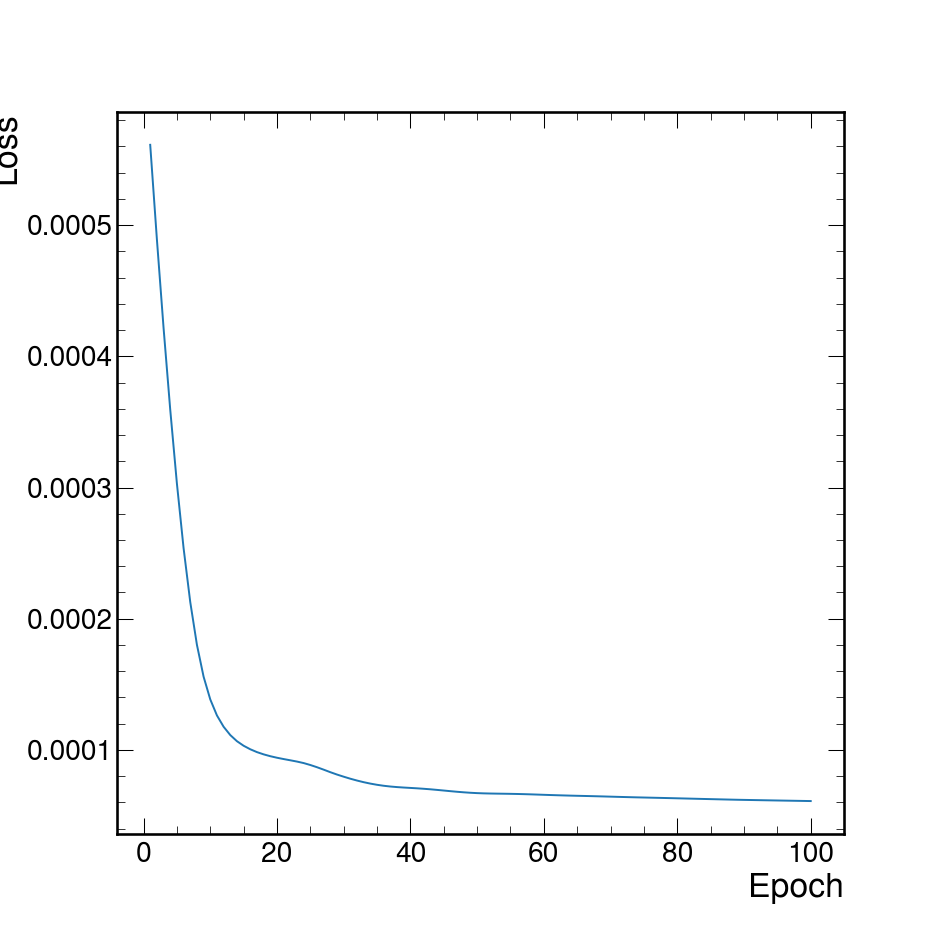

In [53]:
# optimizer = optim.Adam(model.parameters(), lr=0.001)
# lossdata=[]
# epochs=100
# epochlist=[]
# for i in range(0,100):
#     epochlist.append(i+1)
# for i in range(0,epochs):
#     trained=model.forward(train_features_tensor)
#     loss=model.batch_weightedBCELoss(trained,train_labels_tensor,train_weights_tensor,1024)
#     lossdata.append(loss.item())
#     optimizer.zero_grad()
#     loss.backward()
#     optimizer.step()
#     print(f'For Epoch {i+1}: Loss = {loss}')
# figure=plt.figure()
# plt.plot(epochlist,lossdata)
# plt.xlabel('Epoch')
# plt.ylabel('Loss')
# plt.show()    

For Epoch 1: Loss = 0.0002885255089495331
For Epoch 2: Loss = 0.0002669339010026306
For Epoch 3: Loss = 0.0002450601605232805
For Epoch 4: Loss = 0.00022272531350608915
For Epoch 5: Loss = 0.00020218879217281938
For Epoch 6: Loss = 0.00018297416681889445
For Epoch 7: Loss = 0.00016537333431188017
For Epoch 8: Loss = 0.00015006291505414993
For Epoch 9: Loss = 0.0001374628918711096
For Epoch 10: Loss = 0.00012752957991324365
For Epoch 11: Loss = 0.00012036366388201714
For Epoch 12: Loss = 0.00011593527597142383
For Epoch 13: Loss = 0.00011388753773644567
For Epoch 14: Loss = 0.00011365021055098623
For Epoch 15: Loss = 0.0001145295609603636
For Epoch 16: Loss = 0.0001157629958470352
For Epoch 17: Loss = 0.00011677628208417445
For Epoch 18: Loss = 0.00011716166773112491
For Epoch 19: Loss = 0.00011667567741824314
For Epoch 20: Loss = 0.00011528342292876914
For Epoch 21: Loss = 0.00011309868568787351
For Epoch 22: Loss = 0.0001103093454730697
For Epoch 23: Loss = 0.00010713866504374892
For 

<IPython.core.display.Javascript object>


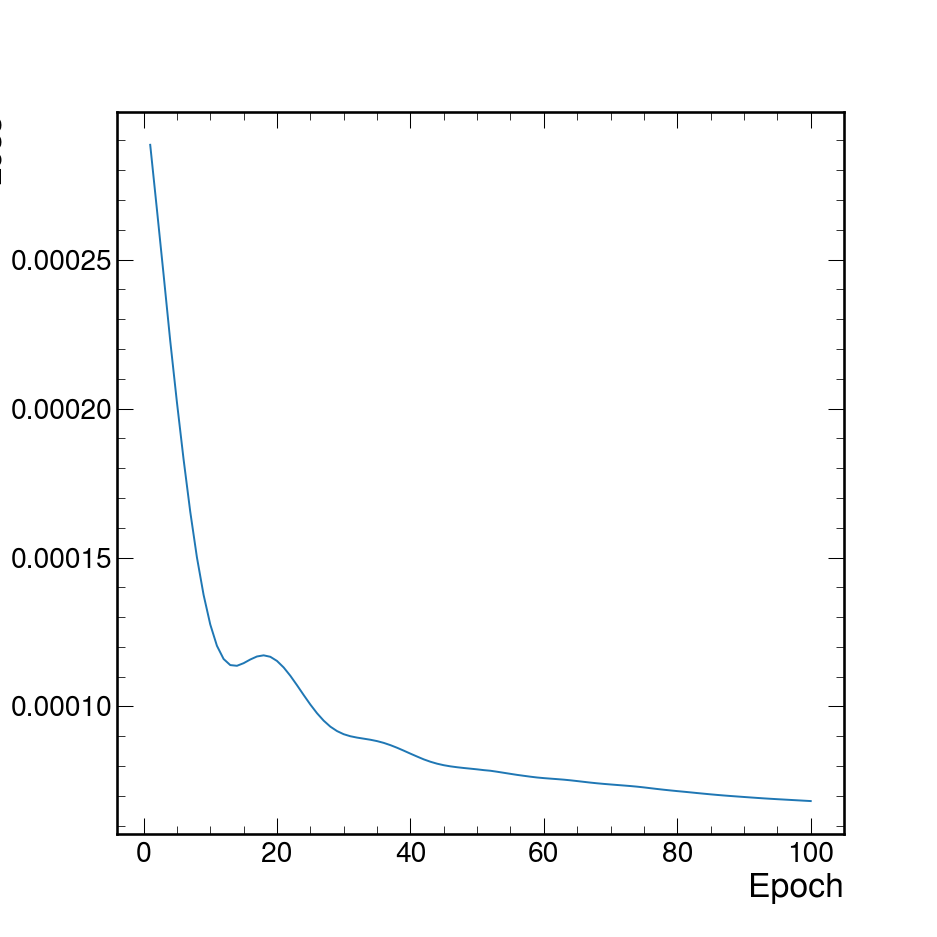

In [138]:
optimizer = optim.Adam(model.parameters(), lr=0.001)
lossdata=[]
df_Prediction=pd.DataFrame()
epochs=100
epochlist=[]
for i in range(1,100+1):
    epochlist.append(i)
for i in range(0,epochs):
    trained=model.forward(train_features_tensor)
    trained_data= pd.DataFrame(trained.detach().numpy())
    df_Prediction[f'Epoch {i}'] = trained_data
    loss=model.batch_weightedBCELoss(trained,train_labels_tensor,train_weights_tensor,1024)
    lossdata.append(loss.item())
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    print(f'For Epoch {i+1}: Loss = {loss}')
figure=plt.figure()
plt.plot(epochlist,lossdata)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()    

<IPython.core.display.Javascript object>


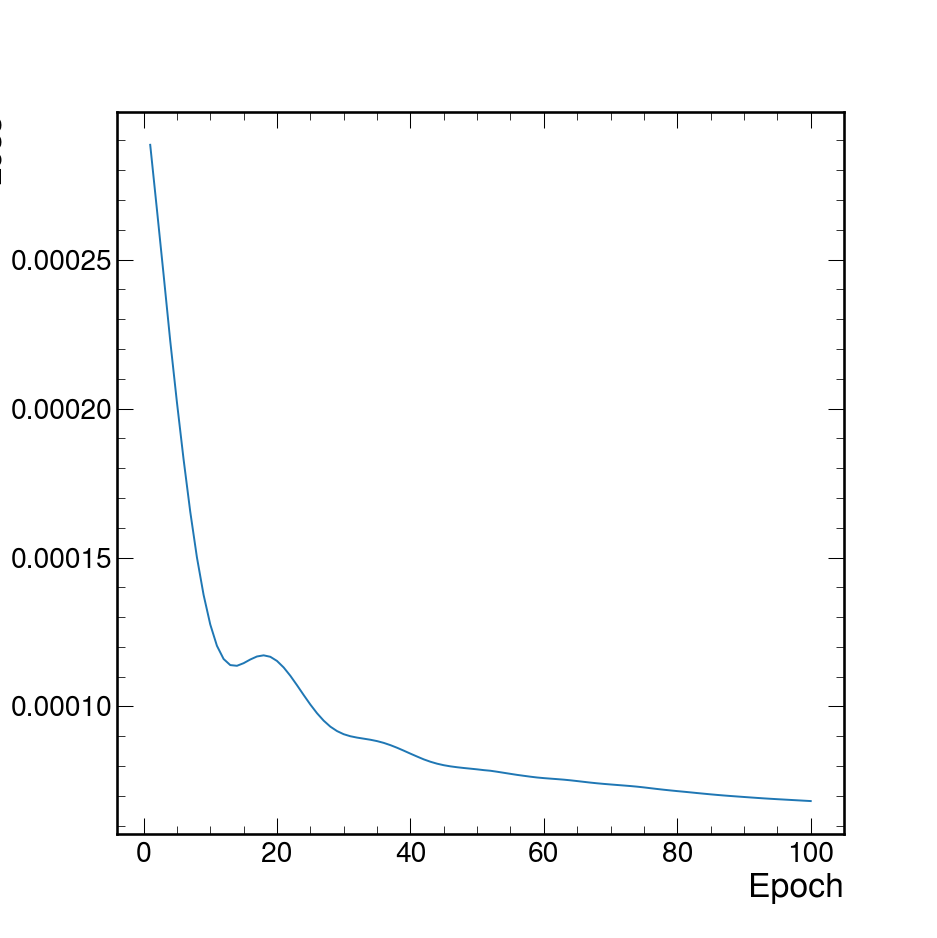

In [139]:
"""
Plot of Loss vs Epoch
"""
figure=plt.figure()
plt.plot(epochlist,lossdata)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()    

In [ ]:
"""Plots histogram for each epoch - not useful"""

# lossdata=[]
# for i in range(0,10):
#     trained=model.forward(train_features_tensor)
#     loss=model.batch_weightedBCELoss(trained,train_labels_tensor,train_weights_tensor,1024)
#     lossdata.append(loss.item())
#     optimizer.zero_grad()
#     loss.backward()
#     optimizer.step()
#     plt.hist(trained.squeeze().tolist(),bins=80,label='predicted',histtype="step")
#     #plt.hist(train_labels_tensor.tolist(),bins=80,label='output',histtype="step")
#     plt.show()
# print(lossdata)

In [ ]:
for i in range(0,100):
    epochlist.append(i+1)
figure=plt.figure()
plt.plot(epochlist,lossdata)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()    

<IPython.core.display.Javascript object>


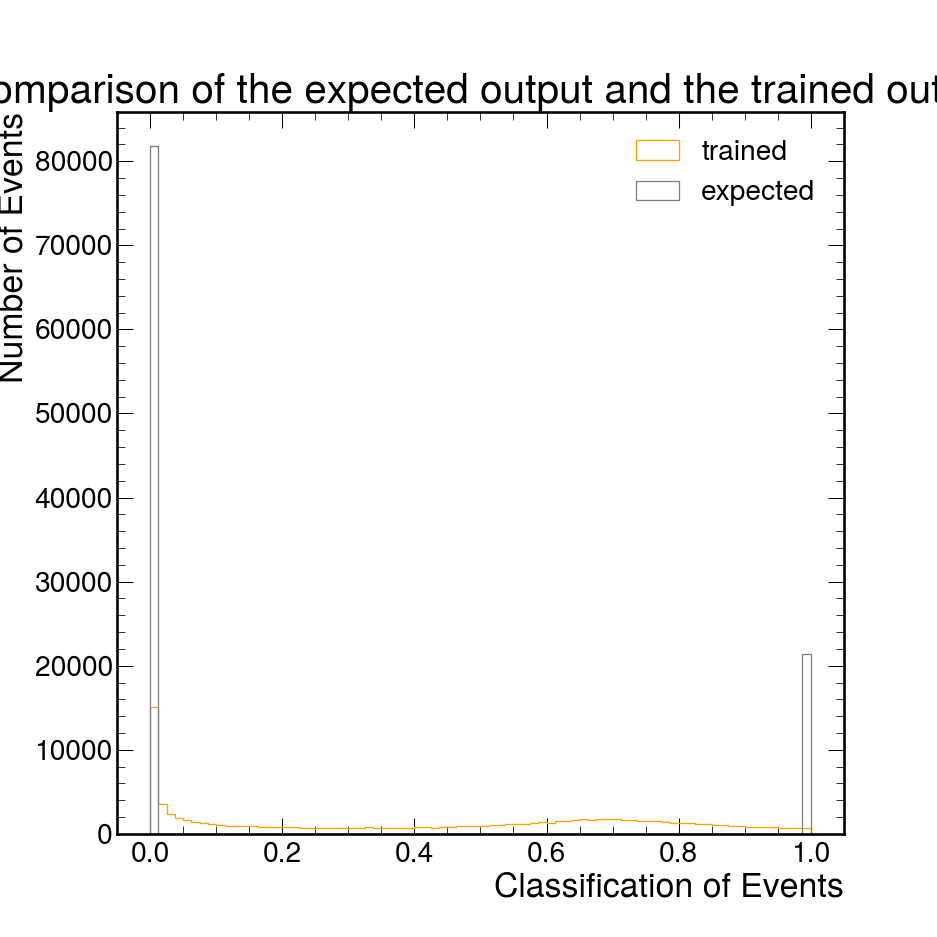

In [140]:
plt.figure()
plt.hist(trained.squeeze().tolist(),bins=80,label='trained',histtype="step",color='orange')
plt.hist(train_labels,bins=80,histtype='step',color='grey',label='expected')
plt.legend()
plt.xlabel('Classification of Events')
plt.ylabel('Number of Events')
plt.title('Comparison of the expected output and the trained output')
#plt.savefig(f"BenNeuralNetworkPlots/TrainingHist-{signalname}Epochs={epochs}")
plt.show()

In [ ]:
from matplotlib.animation import FuncAnimation


# Generate multiple sets of sample data
datasets = [np.random.randn(1000) * (i + 1) for i in range(5)]  # Five different datasets

# Create a figure and axis
fig, ax = plt.subplots()

# Create an empty histogram (initial plot)
hist, bins, _ = ax.hist([], bins=30)  # Empty histogram with initial bins

# Update function for the animation
def update(frame):
    nonlocal hist
    ax.clear()  # Clear the axis for the next frame
    
    if frame < len(datasets):
        data = datasets[frame]
        # Create a histogram for the current dataset
        hist, bins, _ = ax.hist(data, bins=30, color='blue', alpha=0.7)
        ax.set_title(f'Histogram for Dataset {frame + 1}')  # Set title for each dataset
    else:
        ani.event_source.stop()  # Stop the animation if all datasets are displayed
    
    return hist

# Create the animation
ani = FuncAnimation(fig, update, frames=len(datasets) + 1, interval=1000)  # Number of frames includes additional frame to stop

# Show the animation
plt.show()

ani.save('multiple_histograms_animation.gif', writer='pillow')  # Save as GIF format (requires Pillow library)


In [ ]:
for i in range(0,size/batchsize):
    weights = train_weights_tensor[:1024, :]
    labels = train_labels_tensor.unsqueeze(1)[:1024,:]
    training = trained[:1024,:]

In [ ]:
error = weightedBCELoss(training, labels, weights)
error

In [ ]:
df_TopFeatures[df_TopFeatures['Classification']==0].sum()

In [ ]:
batch_size=1024

train=model.forward(train_features_tensor)

total_batch_err=torch.empty(0,1)
output_length=train_weights_tensor.shape[0]
batch_remainder=output_length%batch_size

for i in range(0, output_length//batch_size):
    weights = train_weights_tensor[i*(batch_size):(i+1)*(batch_size), :]
    labels = train_weights_tensor[i*(batch_size):(i+1)*(batch_size), :]
    inputs = train[i*(batch_size):(i+1)*(batch_size), :]

    loss=weightedBCELoss(inputs, labels, weights)
    
    total_batch_err=torch.cat((total_batch_err,loss)) 
    print(total_batch_err.shape[0])
    
if batch_remainder > 0:
    weights = train_weights_tensor[(output_length//batch_size)*batch_size:, :]
    labels = train_weights_tensor[(output_length//batch_size)*batch_size:, :]
    inputs = train[(output_length//batch_size)*batch_size:, :]

    loss=weightedBCELoss(inputs, labels, weights)
    
    weights = train_weights_tensor[(train_weights_tensor.shape[0]//batch_size)*batch_size:, :]
    total_batch_err=torch.cat((total_batch_err,weights))
    print(total_batch_err.shape[0])

In [ ]:
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
import numpy as np

# Create a figure and axis
fig, ax = plt.subplots()
x_data = np.linspace(0, 2*np.pi, 100)
line, = ax.plot([], [], lw=2)

# Initialization function: plot the background of each frame
def init():
    line.set_data([], [])
    return line,

# Animation function: this is called sequentially
def animate(i):
    y_data = np.sin(x_data + 0.1 * i)
    line.set_data(x_data, y_data)
    return line,

# Create animation
anim = FuncAnimation(fig, animate, init_func=init, frames=100, interval=50, blit=True)

# Display the animation
plt.show()

In [ ]:
optimizer = optim.Adam(model.parameters(), lr=0.001)
lossdata=[]
df_Prediction=pd.DataFrame()
epochs=100
epochlist=[]
for i in range(1,100+1):
    epochlist.append(i)
for i in range(0,epochs):
    trained=model.forward(train_features_tensor)
    trained_data= pd.DataFrame(trained.detach().numpy())
    df_Prediction[f'Epoch {i}'] = trained_data
    loss=model.batch_weightedBCELoss(trained,train_labels_tensor,train_weights_tensor,1024)
    lossdata.append(loss.item())
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    print(f'For Epoch {i+1}: Loss = {loss}')
figure=plt.figure()
plt.plot(epochlist,lossdata)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()    

In [ ]:
trained.detach().numpy()

In [ ]:
df_Prediction 

In [ ]:
tensor_data = torch.tensor([[1, 2, 3],
                            [4, 5, 6],
                            [7, 8, 9]])

# Convert PyTorch tensor to a NumPy array
numpy_array = tensor_data.numpy()

# Create a Pandas DataFrame from the NumPy array
df = pd.DataFrame(numpy_array)


In [ ]:
numpy_array

In [ ]:
trained[0:,]

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation

fig, ax = plt.subplots()

haaa=trained.detach().numpy().squeeze()

#x = np.arange(0, 2*np.pi, 0.01)        # x-array
line, = ax.hist(haaa)


def animate(i):
    line.set_ydata(np.sin(x+i/10.0))  # update the data
    return line,

#Init only required for blitting to give a clean slate.
def init():
    line.set_ydata(np.ma.array(x, mask=True))
    return line,

ani = animation.FuncAnimation(fig, animate, np.arange(1, 200), init_func=init,
    interval=25, blit=True)
plt.show()

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.animation as animation

orbit_data = np.array([[[0, 0],
                        [1, 0.5],
                        [2, 0],
                        [1, -0.5],
                        [0, 0]],
                       
                        [[0, 0],
                        [-1, 0.5],
                        [-2, 0],
                        [-1, -0.5],
                        [0, 0]]])

fig, ax = plt.subplots()
ax.set_xlim(-3, 2)
ax.set_ylim(-2, 2)
lines = [ax.plot([], [], lw=2)[0] for _ in range(len(orbit_data))]


def init():
    for line in lines:
        line.set_data([], [])
    return lines

def animate(i):
    for j, line in enumerate(lines):
        line.set_data(orbit_data[j][:i+1, 0], orbit_data[j][:i+1, 1])
        # print(orbit_data[j][i])
    return lines

ani = animation.FuncAnimation(fig, animate, init_func=init, frames=len(orbit_data[0]),
                              interval=100, blit=True)

plt.show()

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation


def animate_solar_system(datafile):
    x = []
    y = []
    orbit_data = []
    
    data = pd.read_csv(datafile)  # Read the CSV file
    planet_columns = [col for col in data.columns if 'Position' in col]  # Select position columns
    # print(data[planet_columns[2]][3])

    # Create the figure, axes and a line for each astro
    fig = plt.figure()

    # ax = plt.axes(xlim=(-2e11, 2e11), ylim=(-2e11, 2e11)) # Will have to change it for the maximum radius
    ax = plt.axes(xlim=(-2, 2), ylim=(-2, 2))
    lines = [ax.plot([], [], linewidth=2, label=col.split('_')[2])[0] for col in planet_columns if 'x' in col]  # 'x' in col avoids having 3 lines for each astro

    # Create orbit_data with the coordinates
    for j, line in enumerate(lines):
        orbit_data.append([[data[planet_columns[3*j]][k], data[planet_columns[3*j+1]][k]] for k in range(len(data[planet_columns[0]]))])
        
    # print(orbit_data)
    orbit_data = np.array(orbit_data, dtype = np.longdouble)
    # print(orbit_data[0])
    
    def init():
        for line in lines:
            line.set_data([], [])
        return lines
    
    def animate(i):
        for j, line in enumerate(lines):
            line.set_data(orbit_data[j][:i+1, 0], orbit_data[j][:i+1, 1])
            print(orbit_data[j][i])
        return lines

    ani = animation.FuncAnimation(fig, animate, init_func=init, frames=len(orbit_data[0]),
                                  interval=100, blit=True)
    # plt.legend()
    plt.show()

# Call the function with the CSV file name as an argument
animate_solar_system('positions3.dat')

run 0
run 1
run 2
run 3
run 4
run 5
run 6
run 7
run 8
run 9
run 10
run 11
run 12
run 13
run 14
run 15
run 16
run 17
run 18
run 19
run 20
run 21
run 22
run 23
run 24
run 25
run 26
run 27
run 28
run 29
run 30
run 31
run 32
run 33
run 34
run 35
run 36
run 37
run 38
run 39
run 40
run 41
run 42
run 43
run 44
run 45
run 46
run 47
run 48
run 49
run 50
run 51
run 52
run 53
run 54
run 55
run 56
run 57
run 58
run 59
run 60
run 61
run 62
run 63
run 64
run 65
run 66
run 67
run 68
run 69
run 70
run 71
run 72
run 73
run 74
run 75
run 76
run 77
run 78
run 79
run 80
run 81
run 82
run 83
run 84
run 85
run 86
run 87
run 88
run 89
run 90
run 91
run 92
run 93
run 94
run 95
run 96
run 97
run 98
run 99
run 100
run 101
run 102
run 103
run 104
run 105
run 106
run 107
run 108
run 109
run 110
run 111
run 112
run 113
run 114
run 115
run 116
run 117
run 118
run 119
run 120
run 121
run 122
run 123
run 124
run 125
run 126
run 127
run 128
run 129
run 130
run 131
run 132
run 133
run 134
run 135
run 136
run 137
run 13

run 1039
run 1040
run 1041
run 1042
run 1043
run 1044
run 1045
run 1046
run 1047
run 1048
run 1049
run 1050
run 1051
run 1052
run 1053
run 1054
run 1055
run 1056
run 1057
run 1058
run 1059
run 1060
run 1061
run 1062
run 1063
run 1064
run 1065
run 1066
run 1067
run 1068
run 1069
run 1070
run 1071
run 1072
run 1073
run 1074
run 1075
run 1076
run 1077
run 1078
run 1079
run 1080
run 1081
run 1082
run 1083
run 1084
run 1085
run 1086
run 1087
run 1088
run 1089
run 1090
run 1091
run 1092
run 1093
run 1094
run 1095
run 1096
run 1097
run 1098
run 1099
run 1100
run 1101
run 1102
run 1103
run 1104
run 1105
run 1106
run 1107
run 1108
run 1109
run 1110
run 1111
run 1112
run 1113
run 1114
run 1115
run 1116
run 1117
run 1118
run 1119
run 1120
run 1121
run 1122
run 1123
run 1124
run 1125
run 1126
run 1127
run 1128
run 1129
run 1130
run 1131
run 1132
run 1133
run 1134
run 1135
run 1136
run 1137
run 1138
run 1139
run 1140
run 1141
run 1142
run 1143
run 1144
run 1145
run 1146
run 1147
run 1148
run 1149
r

run 1953
run 1954
run 1955
run 1956
run 1957
run 1958
run 1959
run 1960
run 1961
run 1962
run 1963
run 1964
run 1965
run 1966
run 1967
run 1968
run 1969
run 1970
run 1971
run 1972
run 1973
run 1974
run 1975
run 1976
run 1977
run 1978
run 1979
run 1980
run 1981
run 1982
run 1983
run 1984
run 1985
run 1986
run 1987
run 1988
run 1989
run 1990
run 1991
run 1992
run 1993
run 1994
run 1995
run 1996
run 1997
run 1998
run 1999
run 2000
run 2001
run 2002
run 2003
run 2004
run 2005
run 2006
run 2007
run 2008
run 2009
run 2010
run 2011
run 2012
run 2013
run 2014
run 2015
run 2016
run 2017
run 2018
run 2019
run 2020
run 2021
run 2022
run 2023
run 2024
run 2025
run 2026
run 2027
run 2028
run 2029
run 2030
run 2031
run 2032
run 2033
run 2034
run 2035
run 2036
run 2037
run 2038
run 2039
run 2040
run 2041
run 2042
run 2043
run 2044
run 2045
run 2046
run 2047
run 2048
run 2049
run 2050
run 2051
run 2052
run 2053
run 2054
run 2055
run 2056
run 2057
run 2058
run 2059
run 2060
run 2061
run 2062
run 2063
r

run 2865
run 2866
run 2867
run 2868
run 2869
run 2870
run 2871
run 2872
run 2873
run 2874
run 2875
run 2876
run 2877
run 2878
run 2879
run 2880
run 2881
run 2882
run 2883
run 2884
run 2885
run 2886
run 2887
run 2888
run 2889
run 2890
run 2891
run 2892
run 2893
run 2894
run 2895
run 2896
run 2897
run 2898
run 2899
run 2900
run 2901
run 2902
run 2903
run 2904
run 2905
run 2906
run 2907
run 2908
run 2909
run 2910
run 2911
run 2912
run 2913
run 2914
run 2915
run 2916
run 2917
run 2918
run 2919
run 2920
run 2921
run 2922
run 2923
run 2924
run 2925
run 2926
run 2927
run 2928
run 2929
run 2930
run 2931
run 2932
run 2933
run 2934
run 2935
run 2936
run 2937
run 2938
run 2939
run 2940
run 2941
run 2942
run 2943
run 2944
run 2945
run 2946
run 2947
run 2948
run 2949
run 2950
run 2951
run 2952
run 2953
run 2954
run 2955
run 2956
run 2957
run 2958
run 2959
run 2960
run 2961
run 2962
run 2963
run 2964
run 2965
run 2966
run 2967
run 2968
run 2969
run 2970
run 2971
run 2972
run 2973
run 2974
run 2975
r

run 3777
run 3778
run 3779
run 3780
run 3781
run 3782
run 3783
run 3784
run 3785
run 3786
run 3787
run 3788
run 3789
run 3790
run 3791
run 3792
run 3793
run 3794
run 3795
run 3796
run 3797
run 3798
run 3799
run 3800
run 3801
run 3802
run 3803
run 3804
run 3805
run 3806
run 3807
run 3808
run 3809
run 3810
run 3811
run 3812
run 3813
run 3814
run 3815
run 3816
run 3817
run 3818
run 3819
run 3820
run 3821
run 3822
run 3823
run 3824
run 3825
run 3826
run 3827
run 3828
run 3829
run 3830
run 3831
run 3832
run 3833
run 3834
run 3835
run 3836
run 3837
run 3838
run 3839
run 3840
run 3841
run 3842
run 3843
run 3844
run 3845
run 3846
run 3847
run 3848
run 3849
run 3850
run 3851
run 3852
run 3853
run 3854
run 3855
run 3856
run 3857
run 3858
run 3859
run 3860
run 3861
run 3862
run 3863
run 3864
run 3865
run 3866
run 3867
run 3868
run 3869
run 3870
run 3871
run 3872
run 3873
run 3874
run 3875
run 3876
run 3877
run 3878
run 3879
run 3880
run 3881
run 3882
run 3883
run 3884
run 3885
run 3886
run 3887
r

run 4690
run 4691
run 4692
run 4693
run 4694
run 4695
run 4696
run 4697
run 4698
run 4699
run 4700
run 4701
run 4702
run 4703
run 4704
run 4705
run 4706
run 4707
run 4708
run 4709
run 4710
run 4711
run 4712
run 4713
run 4714
run 4715
run 4716
run 4717
run 4718
run 4719
run 4720
run 4721
run 4722
run 4723
run 4724
run 4725
run 4726
run 4727
run 4728
run 4729
run 4730
run 4731
run 4732
run 4733
run 4734
run 4735
run 4736
run 4737
run 4738
run 4739
run 4740
run 4741
run 4742
run 4743
run 4744
run 4745
run 4746
run 4747
run 4748
run 4749
run 4750
run 4751
run 4752
run 4753
run 4754
run 4755
run 4756
run 4757
run 4758
run 4759
run 4760
run 4761
run 4762
run 4763
run 4764
run 4765
run 4766
run 4767
run 4768
run 4769
run 4770
run 4771
run 4772
run 4773
run 4774
run 4775
run 4776
run 4777
run 4778
run 4779
run 4780
run 4781
run 4782
run 4783
run 4784
run 4785
run 4786
run 4787
run 4788
run 4789
run 4790
run 4791
run 4792
run 4793
run 4794
run 4795
run 4796
run 4797
run 4798
run 4799
run 4800
r

run 5602
run 5603
run 5604
run 5605
run 5606
run 5607
run 5608
run 5609
run 5610
run 5611
run 5612
run 5613
run 5614
run 5615
run 5616
run 5617
run 5618
run 5619
run 5620
run 5621
run 5622
run 5623
run 5624
run 5625
run 5626
run 5627
run 5628
run 5629
run 5630
run 5631
run 5632
run 5633
run 5634
run 5635
run 5636
run 5637
run 5638
run 5639
run 5640
run 5641
run 5642
run 5643
run 5644
run 5645
run 5646
run 5647
run 5648
run 5649
run 5650
run 5651
run 5652
run 5653
run 5654
run 5655
run 5656
run 5657
run 5658
run 5659
run 5660
run 5661
run 5662
run 5663
run 5664
run 5665
run 5666
run 5667
run 5668
run 5669
run 5670
run 5671
run 5672
run 5673
run 5674
run 5675
run 5676
run 5677
run 5678
run 5679
run 5680
run 5681
run 5682
run 5683
run 5684
run 5685
run 5686
run 5687
run 5688
run 5689
run 5690
run 5691
run 5692
run 5693
run 5694
run 5695
run 5696
run 5697
run 5698
run 5699
run 5700
run 5701
run 5702
run 5703
run 5704
run 5705
run 5706
run 5707
run 5708
run 5709
run 5710
run 5711
run 5712
r

run 6516
run 6517
run 6518
run 6519
run 6520
run 6521
run 6522
run 6523
run 6524
run 6525
run 6526
run 6527
run 6528
run 6529
run 6530
run 6531
run 6532
run 6533
run 6534
run 6535
run 6536
run 6537
run 6538
run 6539
run 6540
run 6541
run 6542
run 6543
run 6544
run 6545
run 6546
run 6547
run 6548
run 6549
run 6550
run 6551
run 6552
run 6553
run 6554
run 6555
run 6556
run 6557
run 6558
run 6559
run 6560
run 6561
run 6562
run 6563
run 6564
run 6565
run 6566
run 6567
run 6568
run 6569
run 6570
run 6571
run 6572
run 6573
run 6574
run 6575
run 6576
run 6577
run 6578
run 6579
run 6580
run 6581
run 6582
run 6583
run 6584
run 6585
run 6586
run 6587
run 6588
run 6589
run 6590
run 6591
run 6592
run 6593
run 6594
run 6595
run 6596
run 6597
run 6598
run 6599
run 6600
run 6601
run 6602
run 6603
run 6604
run 6605
run 6606
run 6607
run 6608
run 6609
run 6610
run 6611
run 6612
run 6613
run 6614
run 6615
run 6616
run 6617
run 6618
run 6619
run 6620
run 6621
run 6622
run 6623
run 6624
run 6625
run 6626
r

run 7430
run 7431
run 7432
run 7433
run 7434
run 7435
run 7436
run 7437
run 7438
run 7439
run 7440
run 7441
run 7442
run 7443
run 7444
run 7445
run 7446
run 7447
run 7448
run 7449
run 7450
run 7451
run 7452
run 7453
run 7454
run 7455
run 7456
run 7457
run 7458
run 7459
run 7460
run 7461
run 7462
run 7463
run 7464
run 7465
run 7466
run 7467
run 7468
run 7469
run 7470
run 7471
run 7472
run 7473
run 7474
run 7475
run 7476
run 7477
run 7478
run 7479
run 7480
run 7481
run 7482
run 7483
run 7484
run 7485
run 7486
run 7487
run 7488
run 7489
run 7490
run 7491
run 7492
run 7493
run 7494
run 7495
run 7496
run 7497
run 7498
run 7499
run 7500
run 7501
run 7502
run 7503
run 7504
run 7505
run 7506
run 7507
run 7508
run 7509
run 7510
run 7511
run 7512
run 7513
run 7514
run 7515
run 7516
run 7517
run 7518
run 7519
run 7520
run 7521
run 7522
run 7523
run 7524
run 7525
run 7526
run 7527
run 7528
run 7529
run 7530
run 7531
run 7532
run 7533
run 7534
run 7535
run 7536
run 7537
run 7538
run 7539
run 7540
r

run 8343
run 8344
run 8345
run 8346
run 8347
run 8348
run 8349
run 8350
run 8351
run 8352
run 8353
run 8354
run 8355
run 8356
run 8357
run 8358
run 8359
run 8360
run 8361
run 8362
run 8363
run 8364
run 8365
run 8366
run 8367
run 8368
run 8369
run 8370
run 8371
run 8372
run 8373
run 8374
run 8375
run 8376
run 8377
run 8378
run 8379
run 8380
run 8381
run 8382
run 8383
run 8384
run 8385
run 8386
run 8387
run 8388
run 8389
run 8390
run 8391
run 8392
run 8393
run 8394
run 8395
run 8396
run 8397
run 8398
run 8399
run 8400
run 8401
run 8402
run 8403
run 8404
run 8405
run 8406
run 8407
run 8408
run 8409
run 8410
run 8411
run 8412
run 8413
run 8414
run 8415
run 8416
run 8417
run 8418
run 8419
run 8420
run 8421
run 8422
run 8423
run 8424
run 8425
run 8426
run 8427
run 8428
run 8429
run 8430
run 8431
run 8432
run 8433
run 8434
run 8435
run 8436
run 8437
run 8438
run 8439
run 8440
run 8441
run 8442
run 8443
run 8444
run 8445
run 8446
run 8447
run 8448
run 8449
run 8450
run 8451
run 8452
run 8453
r

run 9258
run 9259
run 9260
run 9261
run 9262
run 9263
run 9264
run 9265
run 9266
run 9267
run 9268
run 9269
run 9270
run 9271
run 9272
run 9273
run 9274
run 9275
run 9276
run 9277
run 9278
run 9279
run 9280
run 9281
run 9282
run 9283
run 9284
run 9285
run 9286
run 9287
run 9288
run 9289
run 9290
run 9291
run 9292
run 9293
run 9294
run 9295
run 9296
run 9297
run 9298
run 9299
run 9300
run 9301
run 9302
run 9303
run 9304
run 9305
run 9306
run 9307
run 9308
run 9309
run 9310
run 9311
run 9312
run 9313
run 9314
run 9315
run 9316
run 9317
run 9318
run 9319
run 9320
run 9321
run 9322
run 9323
run 9324
run 9325
run 9326
run 9327
run 9328
run 9329
run 9330
run 9331
run 9332
run 9333
run 9334
run 9335
run 9336
run 9337
run 9338
run 9339
run 9340
run 9341
run 9342
run 9343
run 9344
run 9345
run 9346
run 9347
run 9348
run 9349
run 9350
run 9351
run 9352
run 9353
run 9354
run 9355
run 9356
run 9357
run 9358
run 9359
run 9360
run 9361
run 9362
run 9363
run 9364
run 9365
run 9366
run 9367
run 9368
r

<IPython.core.display.Javascript object>


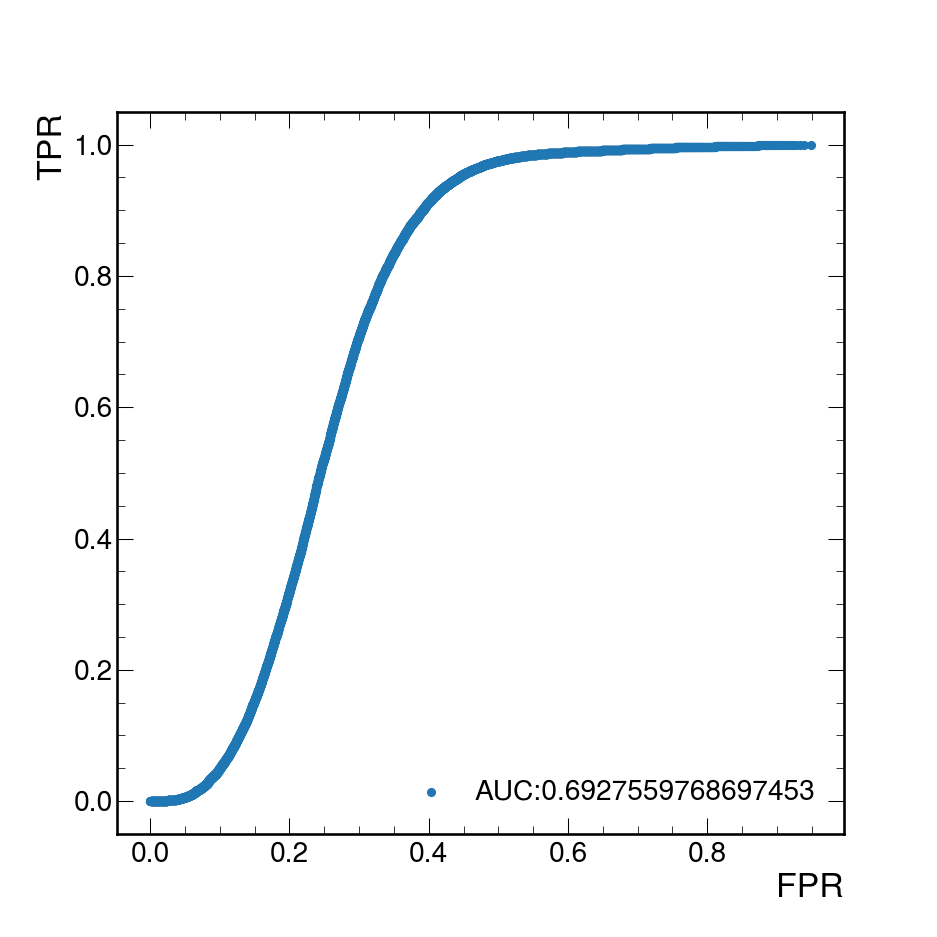

0.6927559768697453


In [154]:
epoch_= 'Epoch 99'

train_labels_=pd.DataFrame({'Classification': train_labels}).reset_index(drop=True)
df_Prediction = pd.concat([df_Prediction, train_labels_], axis=1)


df_Prediction.sort_values(by=[epoch_,'Classification'], ascending=True)
import scipy as scipy

#%%
direction='above' #use this to determine the side of the threshold that calculates TPR and FPR

threshold_direction = f'Signal is {direction} Background'


minimum_edge=0
maximum_edge=1
steps=10000
stepsize=(maximum_edge-minimum_edge)/steps

threshold=minimum_edge
TPR_arr = []
FPR_arr = []
for i in range(0,steps): 
    if threshold_direction == 'Signal is above Background':
        threshold += stepsize
       
        TP = len(df_Prediction[(df_Prediction[epoch_] >= threshold) & (df_Prediction['Classification']==1)][epoch_])#
        FP = len(df_Prediction[(df_Prediction[epoch_] >= threshold) & (df_Prediction['Classification']==0)][epoch_])#
        FN = len(df_Prediction[(df_Prediction[epoch_] < threshold) & (df_Prediction['Classification']==1)][epoch_])#
        TN = len(df_Prediction[(df_Prediction[epoch_] < threshold) & (df_Prediction['Classification']==0)][epoch_])#
        
        print('run',i)
        if (TP+FN) == 0:
            TPR = 0
            FPR = 0
        else:
            TPR = TP/(TP +FN)
            FPR = FP/(FP +TN)
        TPR_arr.append(TPR)
        FPR_arr.append(FPR)
        
    elif threshold_direction == 'Signal is below Background':
        threshold += stepsize
       
        TP = len(df_Prediction[(df_Prediction[epoch_] <= threshold) & (df_Prediction['Classification']==1)][epoch_])#
        FP = len(df_Prediction[(df_Prediction[epoch_] <= threshold) & (df_Prediction['Classification']==0)][epoch_])#
        FN = len(df_Prediction[(df_Prediction[epoch_] > threshold) & (df_Prediction['Classification']==1)][epoch_])#
        TN = len(df_Prediction[(df_Prediction[epoch_] > threshold) & (df_Prediction['Classification']==0)][epoch_])#
        
        print('run',i)
        
        TPR = TP/(TP +FN)
        FPR = FP/(FP +TN)
        TPR_arr.append(TPR)
        FPR_arr.append(FPR)
        


sorted_values = sorted(zip(FPR_arr, TPR_arr))
FPR_arr, TPR_arr = zip(*sorted_values)

AUCscore=scipy.integrate.trapezoid(TPR_arr,FPR_arr,  dx=stepsize,axis=-1)
fig=plt.figure()    
plt.scatter(FPR_arr,TPR_arr,label=f'AUC:{AUCscore}')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.legend()
plt.show()
print(AUCscore)


<IPython.core.display.Javascript object>


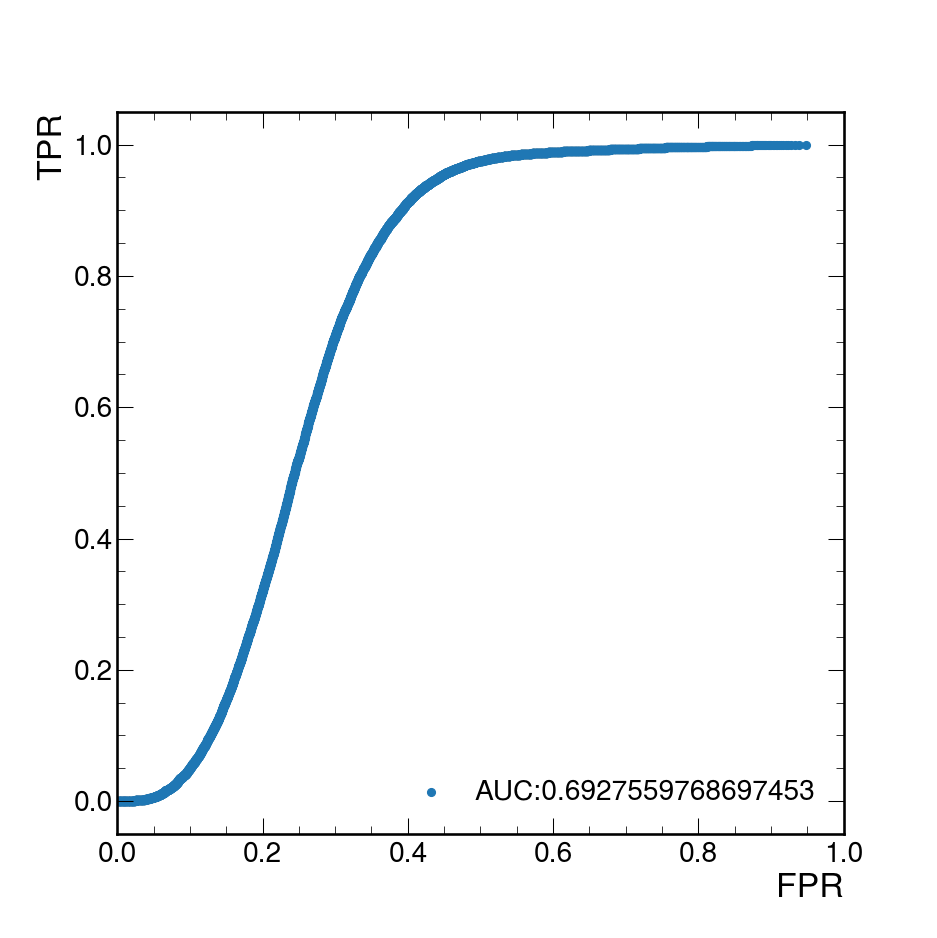

0.6927559768697453


In [155]:
AUCScore =scipy.integrate.trapezoid(TPR_arr,FPR_arr,  dx=stepsize,axis=-1)
fig=plt.figure()    
plt.scatter(FPR_arr,TPR_arr,label=f'AUC:{AUCscore}')
plt.xlabel('FPR')
plt.xlim([0,1])
plt.ylabel('TPR')
plt.legend()
plt.show()
print(AUCscore)


In [153]:
df_Prediction=df_Prediction.drop(columns='Classification')

In [94]:
#df_Prediction['Classification']=pd.DataFrame(train_labels)

train_labels=pd.DataFrame({'Classification': train_labels}).reset_index(drop=True)
df_Prediction = pd.concat([df_Prediction, train_labels], axis=1)

df_Prediction

,Epoch 0,Epoch 1,Epoch 2,Epoch 3,Epoch 4,Epoch 5,Epoch 6,Epoch 7,Epoch 8,Epoch 9,...,Epoch 91,Epoch 92,Epoch 93,Epoch 94,Epoch 95,Epoch 96,Epoch 97,Epoch 98,Epoch 99,Classification
0,1.489176e-03,3.910137e-03,0.010230,0.026490,0.066689,0.156841,0.321257,0.535752,0.725753,0.849232,...,0.040920,0.041183,0.041337,0.041311,0.041047,0.040512,0.039689,0.038584,0.037216,0.0
1,1.421042e-04,5.830317e-04,0.002387,0.009710,0.038468,0.138742,0.385631,0.697259,0.885839,0.959334,...,0.990299,0.990816,0.991275,0.991665,0.991982,0.992226,0.992397,0.992499,0.992534,1.0
2,1.078240e-04,5.994973e-04,0.003330,0.018285,0.093750,0.361664,0.749148,0.936065,0.984770,0.996041,...,0.975618,0.976829,0.977921,0.978850,0.979590,0.980130,0.980464,0.980596,0.980531,1.0
3,3.192072e-07,1.764818e-06,0.000010,0.000054,0.000278,0.001446,0.007195,0.032586,0.123436,0.340961,...,0.000009,0.000009,0.000008,0.000008,0.000008,0.000008,0.000007,0.000007,0.000006,0.0
4,2.370092e-04,5.391529e-04,0.001224,0.002768,0.006115,0.013154,0.027545,0.054904,0.101616,0.171030,...,0.004361,0.004452,0.004528,0.004580,0.004603,0.004593,0.004547,0.004467,0.004353,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
134398,8.074111e-08,4.102526e-07,0.000002,0.000011,0.000053,0.000264,0.001268,0.005692,0.023034,0.079959,...,0.810212,0.822050,0.832729,0.842155,0.850298,0.857184,0.862876,0.867460,0.871040,1.0
134399,2.572569e-01,2.966451e-01,0.340937,0.388333,0.437985,0.488638,0.538515,0.585637,0.628176,0.665269,...,0.647165,0.649293,0.651319,0.653168,0.654784,0.656125,0.657164,0.657889,0.658302,0.0
134400,2.528540e-03,4.346208e-03,0.007454,0.012739,0.021636,0.036313,0.059576,0.092592,0.134850,0.186406,...,0.080326,0.081444,0.082348,0.082969,0.083252,0.083162,0.082676,0.081795,0.080528,0.0
134401,8.567349e-04,1.790045e-03,0.003737,0.007786,0.016121,0.032872,0.064835,0.120527,0.205653,0.316335,...,0.030119,0.030339,0.030477,0.030497,0.030367,0.030072,0.029601,0.028959,0.028156,0.0


In [88]:
train_labels=pd.DataFrame({'Classification': train_labels}).reset_index(drop=True)

ValueError: If using all scalar values, you must pass an index

In [146]:
df_Prediction = df_Prediction.drop(columns='Classification')

In [124]:
df_Prediction

,Epoch 0,Epoch 1,Epoch 2,Epoch 3,Epoch 4,Epoch 5,Epoch 6,Epoch 7,Epoch 8,Epoch 9,...,Epoch 90,Epoch 91,Epoch 92,Epoch 93,Epoch 94,Epoch 95,Epoch 96,Epoch 97,Epoch 98,Epoch 99
0,0.999952,0.999885,0.999724,0.999338,0.998422,0.996265,0.991304,0.980407,0.958616,0.921998,...,0.965265,0.964925,0.964647,0.964475,0.964435,0.964540,0.964782,0.965130,0.965546,0.965993
1,0.983847,0.976748,0.966669,0.952500,0.932852,0.906155,0.870979,0.826742,0.775026,0.720904,...,0.474873,0.472360,0.470074,0.468137,0.466615,0.465550,0.464912,0.464622,0.464577,0.464668
2,0.988555,0.983323,0.975787,0.965018,0.949809,0.928696,0.900160,0.863150,0.811173,0.742267,...,0.007307,0.007110,0.006926,0.006760,0.006610,0.006478,0.006362,0.006259,0.006165,0.006078
3,0.926905,0.902187,0.870390,0.827953,0.765969,0.690426,0.604119,0.512905,0.424732,0.347585,...,0.067942,0.066082,0.064331,0.062707,0.061215,0.059859,0.058624,0.057493,0.056441,0.055447
4,0.997521,0.995881,0.993169,0.988709,0.981427,0.969692,0.951205,0.923182,0.877545,0.804447,...,0.003430,0.003316,0.003212,0.003118,0.003036,0.002965,0.002904,0.002851,0.002804,0.002762
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
134398,0.988085,0.982272,0.973760,0.961425,0.943817,0.919240,0.886108,0.843820,0.794348,0.743607,...,0.560261,0.555886,0.551686,0.547784,0.544249,0.541132,0.538409,0.536000,0.533806,0.531720
134399,0.998241,0.997269,0.995770,0.993465,0.989943,0.984611,0.976164,0.963532,0.945709,0.922371,...,0.001514,0.001488,0.001463,0.001442,0.001425,0.001411,0.001400,0.001392,0.001385,0.001380
134400,0.999999,0.999998,0.999993,0.999979,0.999938,0.999821,0.999486,0.998568,0.996217,0.990900,...,0.000017,0.000015,0.000014,0.000013,0.000012,0.000011,0.000010,0.000010,0.000009,0.000009
134401,0.990151,0.978805,0.956542,0.913343,0.835505,0.712027,0.550681,0.385950,0.255666,0.172748,...,0.991752,0.991798,0.991846,0.991898,0.991956,0.992019,0.992087,0.992159,0.992234,0.992308
